In [1]:
# start here by entering a ticker symbol
ticker = "FLGT"
# number of weeks to look back
weeks = 13
# and watch the magic happen below...
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from empyrical import max_drawdown, alpha, beta
from sklearn.preprocessing import MinMaxScaler
from src.asset_selector import AssetSelector
from src.indicators import Indicators
from util import time_formatter
from src.predictor import Predictor
from sklearn.cluster import KMeans
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import pandas as pd
import numpy as np
import configparser
import requests
import json
import time
import sys
import os
backdate = time_formatter(time.time() - (604800 * weeks))
config = configparser.ConfigParser()
try:
    config.read(os.path.relpath("config.ini"))
except FileExistsError as e:
    print("FileExistsError: {}".format(e))
    sys.exit(1)
alpaca_api = tradeapi.REST(
    base_url    = config["alpaca"]["APCA_API_BASE_URL"],
    key_id      = config["alpaca"]["APCA_API_KEY_ID"],
    secret_key  = config["alpaca"]["APCA_API_SECRET_KEY"],
    api_version = config["alpaca"]["VERSION"]
)
trading_account = alpaca_api.get_account()
sid = SentimentIntensityAnalyzer()
def get_sentiment(text):
    """Given a text block, return a sentiment score based.
    :param text:
    :return:
    """
    text_polarity   = sid.polarity_scores(text)
    print("Polarity:\n", text_polarity)
    if text_polarity["compound"] > 0.50:
        sentiment   = "positive"
    else:
        sentiment   = "negative"
    return sentiment
def get_losers():
    
    print('Losers'.center(45))
    print()
    print('Symbol'.ljust(10), 'Last'.ljust(11), 'Change'.ljust(11), 'Pct Loss')
    print("{:<30}".format('–' * 45))
    for symbol in range(len(alpaca_api.polygon.gainers_losers("losers"))):
        print(alpaca_api.polygon.gainers_losers("losers")[symbol].ticker.ljust(10),
              '$' + str(alpaca_api.polygon.gainers_losers("losers")[symbol].lastTrade['p']).ljust(10),
              '$' + str(alpaca_api.polygon.gainers_losers("losers")[symbol].todaysChange).ljust(10),
              str(alpaca_api.polygon.gainers_losers("losers")[symbol].todaysChangePerc)+'%')
def get_gainers():
    print('Gainers'.center(45))
    print()
    print('Symbol'.ljust(10), 'Last'.ljust(11), 'Change'.ljust(11), 'Pct Gain')
    print("{:<30}".format('–' * 45))
    for symbol in range(len(alpaca_api.polygon.gainers_losers())):
        print(alpaca_api.polygon.gainers_losers()[symbol].ticker.ljust(10),
              '$' + str(alpaca_api.polygon.gainers_losers()[symbol].lastTrade['p']).ljust(10),
              '$' + str(alpaca_api.polygon.gainers_losers()[symbol].todaysChange).ljust(10),
              str(alpaca_api.polygon.gainers_losers()[symbol].todaysChangePerc)+'%')
selector            = AssetSelector(alpaca_api, edgar_token=None)
indicators          = Indicators(alpaca_api)
day_bars            = selector.get_barset(ticker, "day", backdate)
day_bars            = selector.extract_bar_data(day_bars, ticker)
minute_bars         = selector.get_barset(ticker, "minute", backdate)
minute_bars         = selector.extract_bar_data(minute_bars, ticker)
day_spy_bars        = selector.get_barset("SPY", "1D", backdate)
day_spy_bars        = selector.extract_bar_data(day_spy_bars, "SPY")
minute_spy_bars     = selector.get_barset("SPY", "minute", backdate)
minute_spy_bars     = selector.extract_bar_data(minute_spy_bars, "SPY")
ticker_cluster      = indicators.cluster_prep(ticker)
# TODO: Add new sets of bars (same ticker, differnt date) for validation of ML training
results             = requests.post("https://api.stocktwits.com/api/2/streams/symbol/{}.json".format(ticker))
results             = json.loads(results.text)
bodies              = "\n".join([m["body"] for m in results["messages"]])
sentiment           = get_sentiment(bodies)
sentiment

/home/ben/anaconda3/envs/alpaca_test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ben/anaconda3/envs/alpaca_test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ben/anaconda3/envs/alpaca_test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ben/anaconda3/envs/alpaca_test/lib

Polarity:
 {'neg': 0.024, 'neu': 0.834, 'pos': 0.142, 'compound': 0.997}


'positive'

# Exploratory graphs (using day bars)

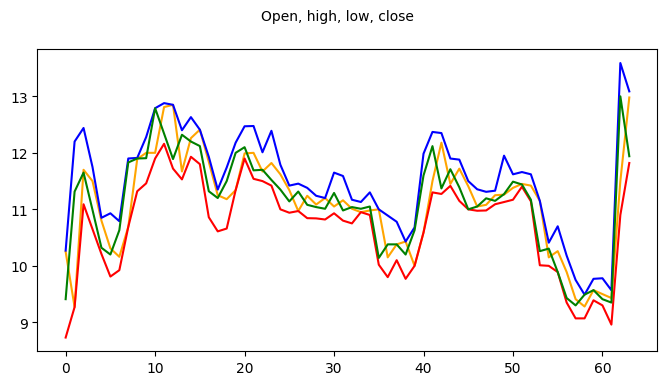

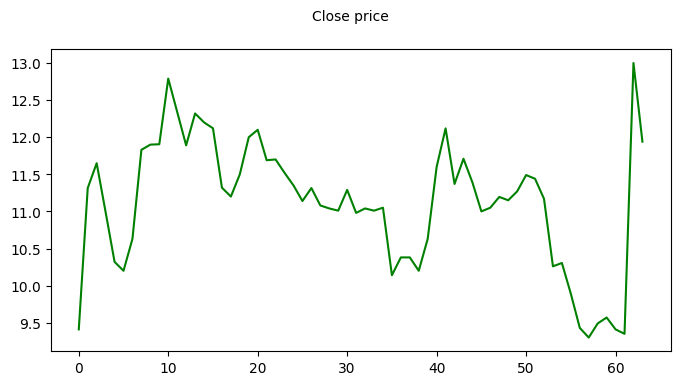

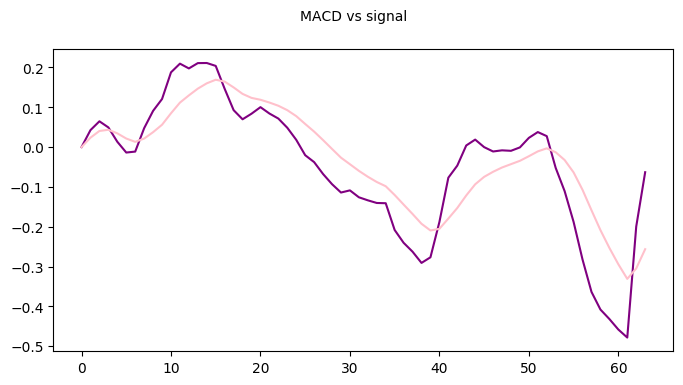

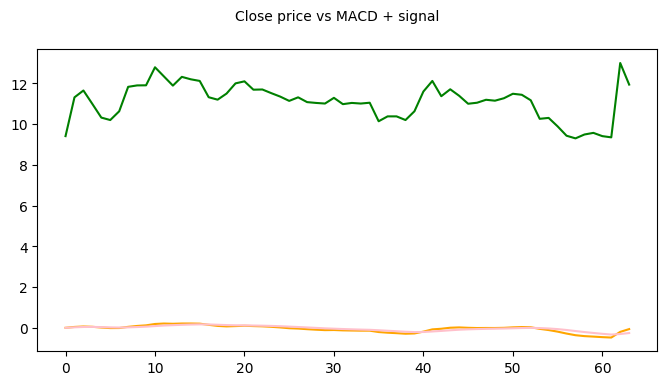

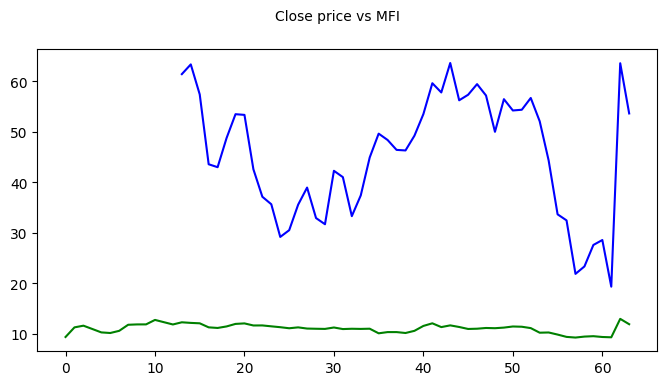

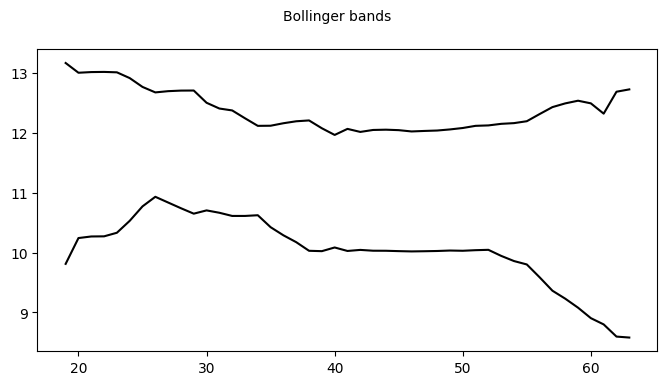

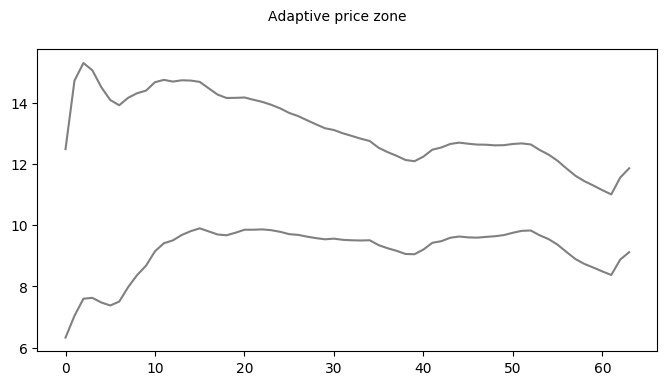

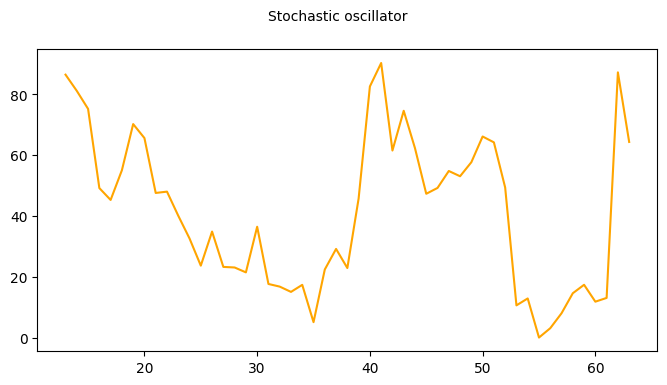

In [2]:
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Open, high, low, close", fontsize=10)
plt.plot(ticker_cluster["open"], color="orange")
plt.plot(ticker_cluster["high"], color="blue")
plt.plot(ticker_cluster["low"], color="red")
plt.plot(ticker_cluster["close"], color="green")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Close price", fontsize=10)
plt.plot(ticker_cluster["close"], color="green")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("MACD vs signal", fontsize=10)
plt.plot(ticker_cluster["macd"], color="purple")
plt.plot(ticker_cluster["signal"], color="pink")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Close price vs MACD + signal", fontsize=10)
plt.plot(ticker_cluster["close"], color="green")
plt.plot(ticker_cluster["macd"], color="orange")
plt.plot(ticker_cluster["signal"], color="pink")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Close price vs MFI", fontsize=10)
plt.plot(ticker_cluster["close"], color="green")
plt.plot(ticker_cluster["mfi"], color="blue")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Bollinger bands", fontsize=10)
plt.plot(ticker_cluster["bb_up"], color="black")
plt.plot(ticker_cluster["bb_low"], color="black")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Adaptive price zone", fontsize=10)
plt.plot(ticker_cluster["apz_u"], color="grey")
plt.plot(ticker_cluster["apz_l"], color="grey")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Stochastic oscillator", fontsize=10)
plt.plot(ticker_cluster["stoch"], color="orange")

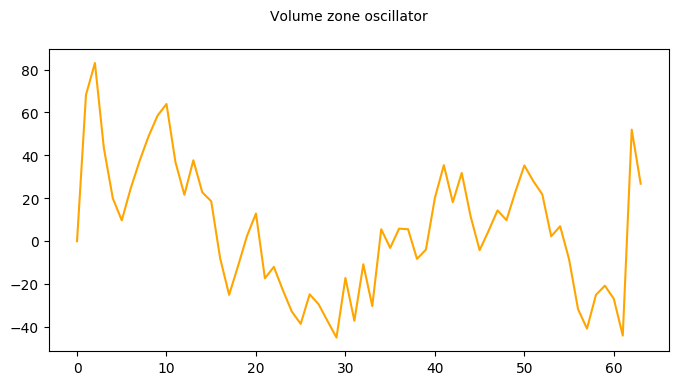

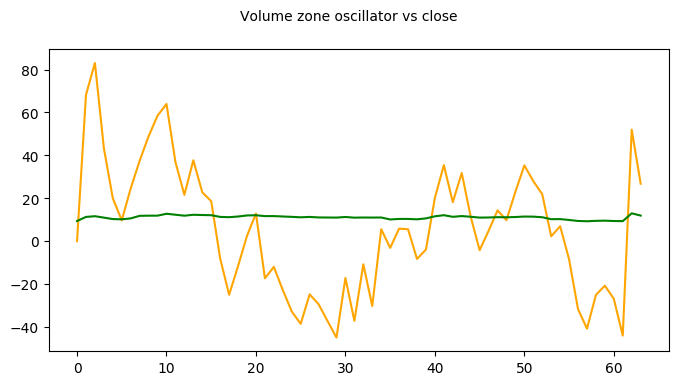

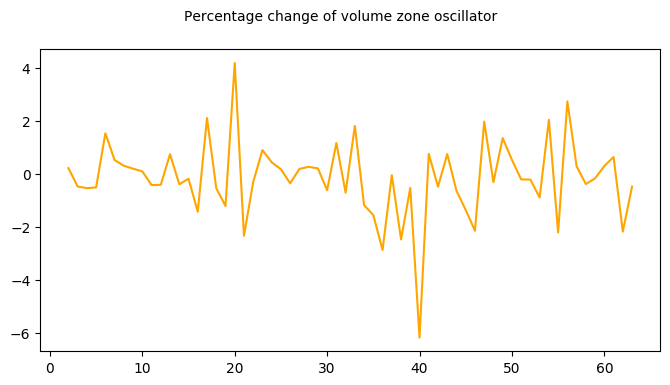

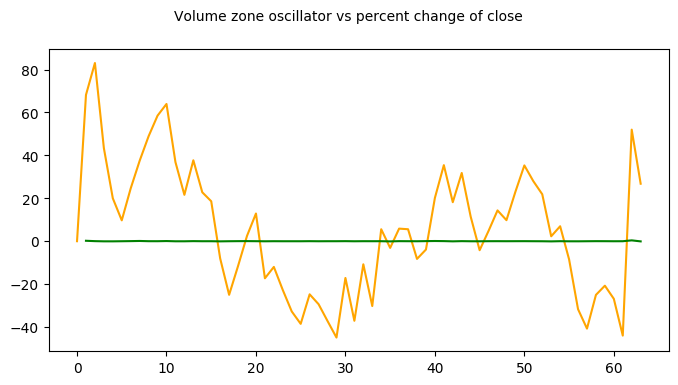

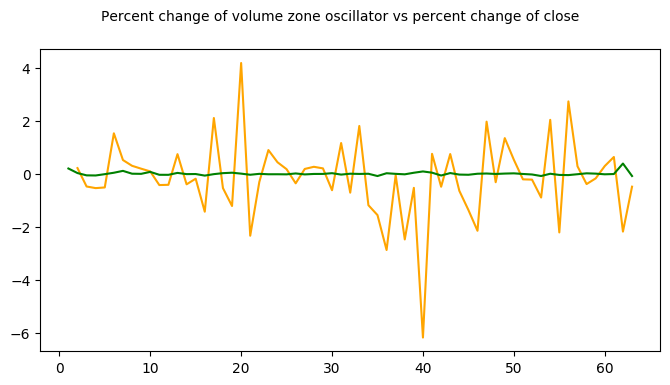

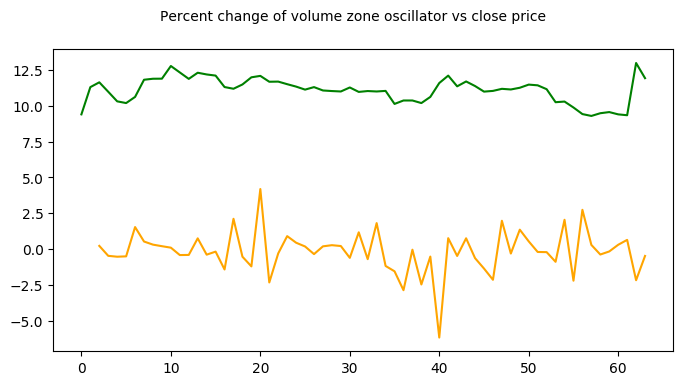

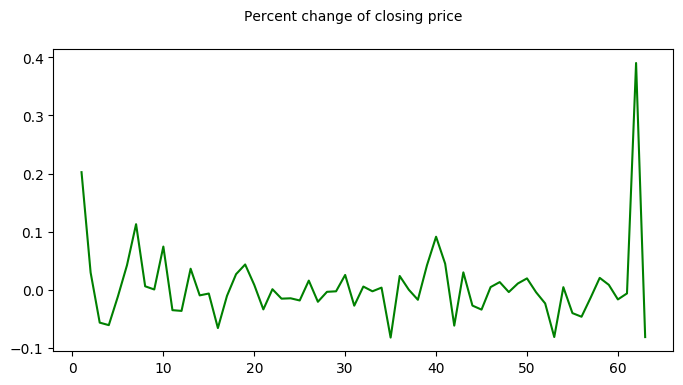

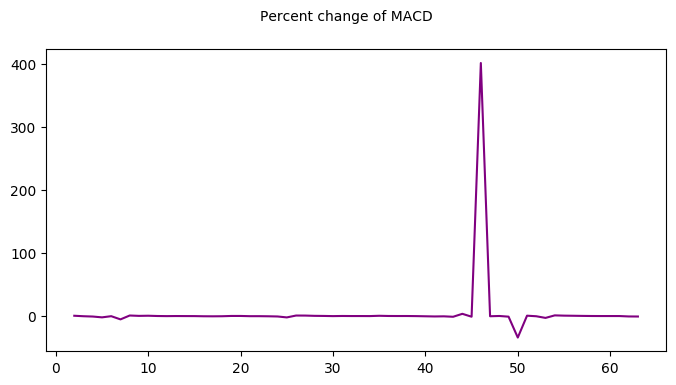

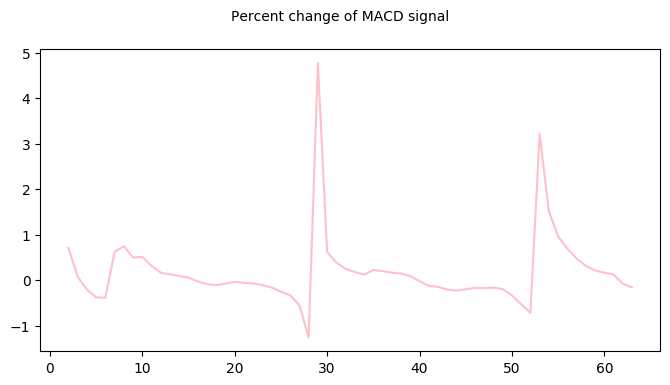

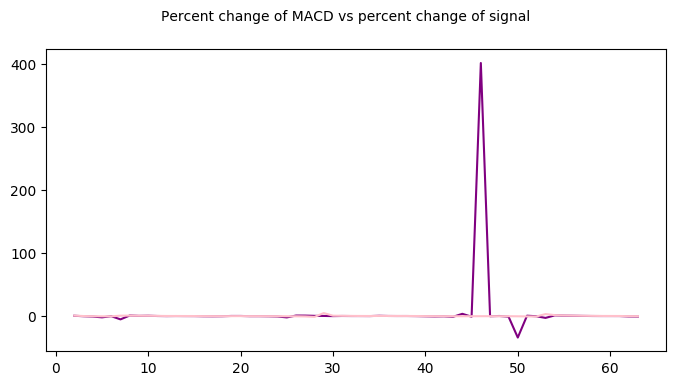

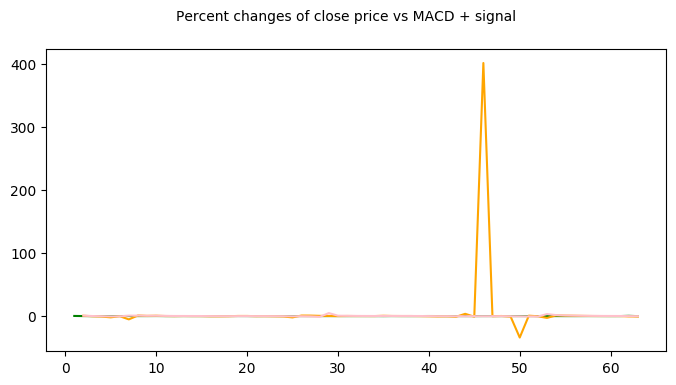

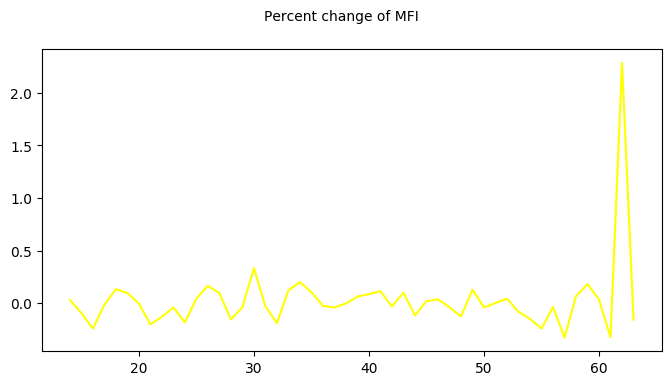

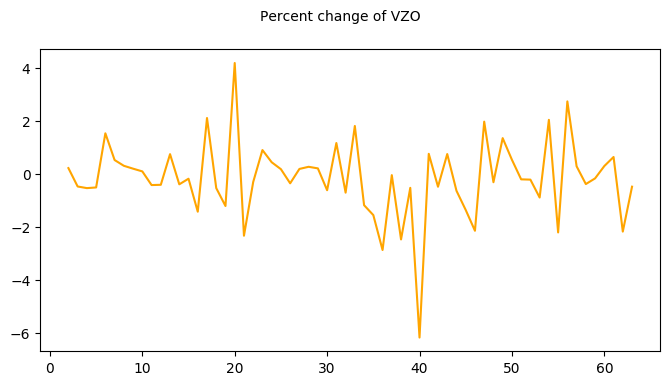

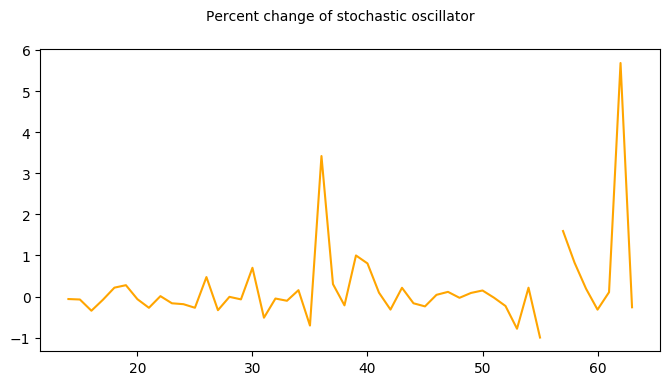

In [3]:
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Volume zone oscillator", fontsize=10)
plt.plot(ticker_cluster["vzo"], color="orange")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Volume zone oscillator vs close", fontsize=10)
plt.plot(ticker_cluster["vzo"], color="orange")
plt.plot(ticker_cluster["close"], color="green")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Percentage change of volume zone oscillator", fontsize=10)
plt.plot(ticker_cluster["vzo"].pct_change(), color="orange")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Volume zone oscillator vs percent change of close", fontsize=10)
plt.plot(ticker_cluster["vzo"], color="orange")
plt.plot(ticker_cluster["close"].pct_change(), color="green")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Percent change of volume zone oscillator vs percent change of close", fontsize=10)
plt.plot(ticker_cluster["vzo"].pct_change(), color="orange")
plt.plot(ticker_cluster["close"].pct_change(), color="green")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Percent change of volume zone oscillator vs close price", fontsize=10)
plt.plot(ticker_cluster["vzo"].pct_change(), color="orange")
plt.plot(ticker_cluster["close"], color="green")
# fig = plt.figure(figsize=(8,4), dpi=100)
# fig.suptitle("ADX", fontsize=10)
# plt.plot(ticker_cluster["adx"], color="green")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Percent change of closing price", fontsize=10)
plt.plot(ticker_cluster["close"].pct_change(), color="green")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Percent change of MACD", fontsize=10)
plt.plot(ticker_cluster["macd"].pct_change(), color="purple")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Percent change of MACD signal", fontsize=10)
plt.plot(ticker_cluster["signal"].pct_change(), color="pink")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Percent change of MACD vs percent change of signal", fontsize=10)
plt.plot(ticker_cluster["macd"].pct_change(), color="purple")
plt.plot(ticker_cluster["signal"].pct_change(), color="pink")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Percent changes of close price vs MACD + signal", fontsize=10)
plt.plot(ticker_cluster["close"].pct_change(), color="green")
plt.plot(ticker_cluster["macd"].pct_change(), color="orange")
plt.plot(ticker_cluster["signal"].pct_change(), color="pink")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Percent change of MFI", fontsize=10)
plt.plot(ticker_cluster["mfi"].pct_change(), color="yellow")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Percent change of VZO", fontsize=10)
plt.plot(ticker_cluster["vzo"].pct_change(), color="orange")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Percent change of stochastic oscillator", fontsize=10)
plt.plot(ticker_cluster["stoch"].pct_change(), color="orange")

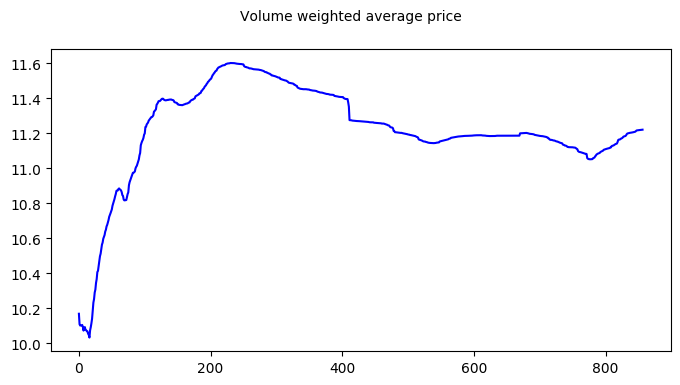

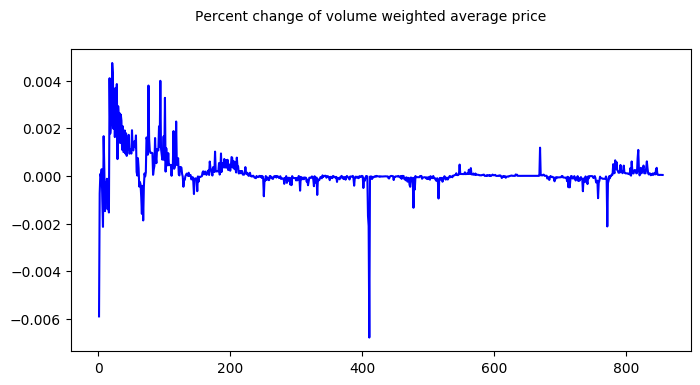

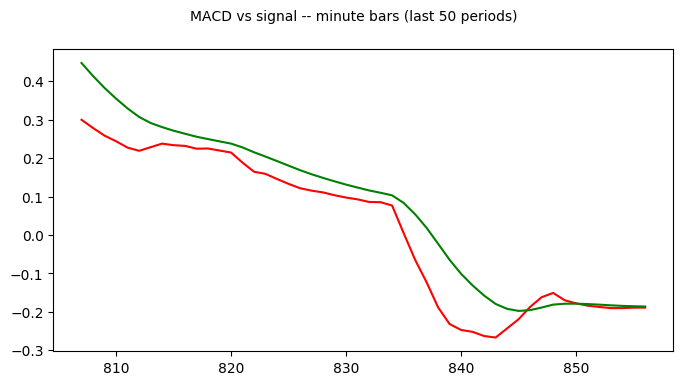

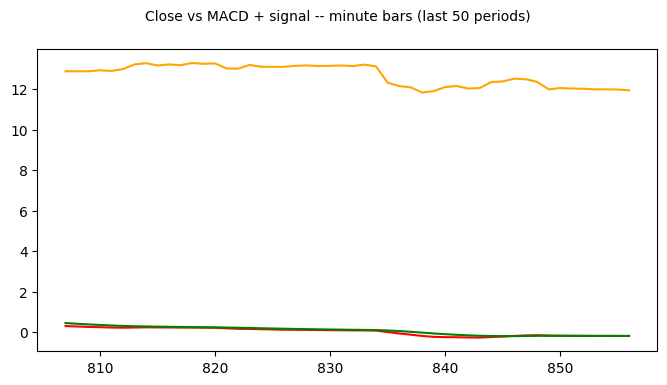

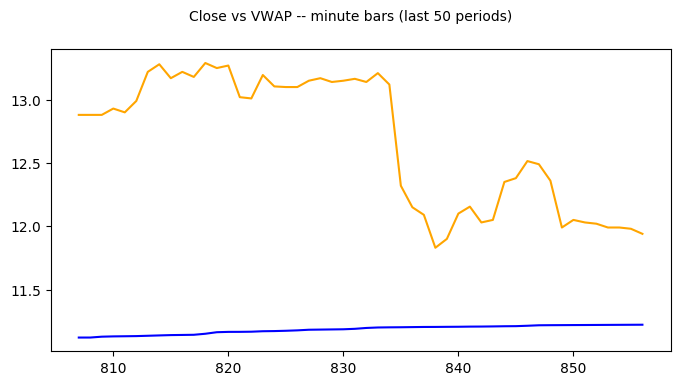

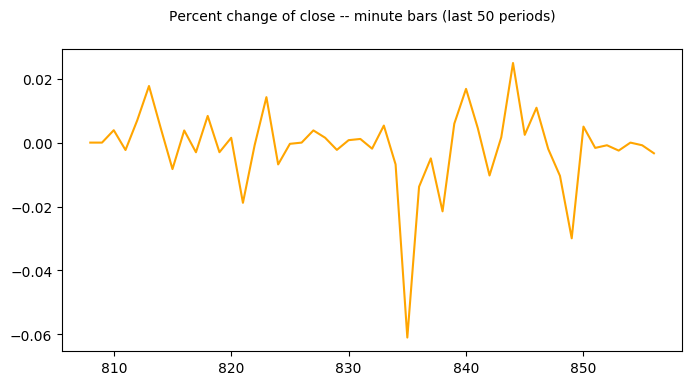

In [4]:
vwap = indicators.get_vwap(minute_bars)
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Volume weighted average price", fontsize=10)
plt.plot(vwap, color="blue")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Percent change of volume weighted average price", fontsize=10)
plt.plot(vwap.pct_change(), color="blue")
minute_macd = indicators.get_macd(minute_bars)
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("MACD vs signal -- minute bars (last 50 periods)", fontsize=10)
plt.plot(minute_macd["MACD"].iloc[-50:], color="red")
plt.plot(minute_macd["SIGNAL"].iloc[-50:], color="green")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Close vs MACD + signal -- minute bars (last 50 periods)", fontsize=10)
plt.plot(minute_bars["close"].iloc[-50:], color="orange")
plt.plot(minute_macd["MACD"].iloc[-50:], color="red")
plt.plot(minute_macd["SIGNAL"].iloc[-50:], color="green")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Close vs VWAP -- minute bars (last 50 periods)", fontsize=10)
plt.plot(minute_bars["close"].iloc[-50:], color="orange")
plt.plot(vwap.iloc[-50:], color="blue")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Percent change of close -- minute bars (last 50 periods)", fontsize=10)
plt.plot(minute_bars["close"].iloc[-50:].pct_change(), color="orange")
# calculate the max drawdown
# max_drawdown = max_drawdown(minute_bars["close"])
# day_bars.iloc[-50:]
# minute_bars["close"]
# day_spy_bars.iloc[-50:]
# calculate alpha and beta
# alpha = alpha(minute_bars["close"], minute_spy_bars["close"])
# beta = beta(minute_bars["close"], minute_spy_bars["close"])
# print(alpha, beta, max_drawdown)

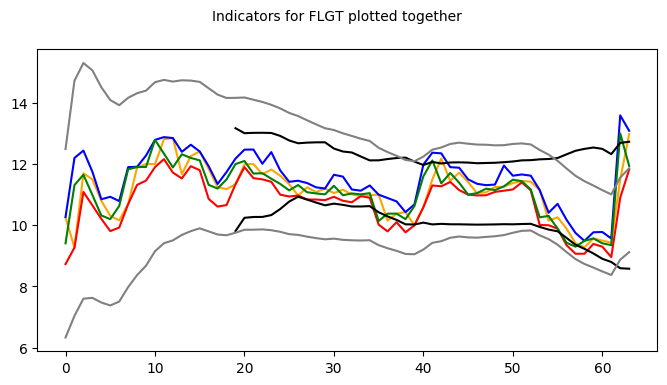

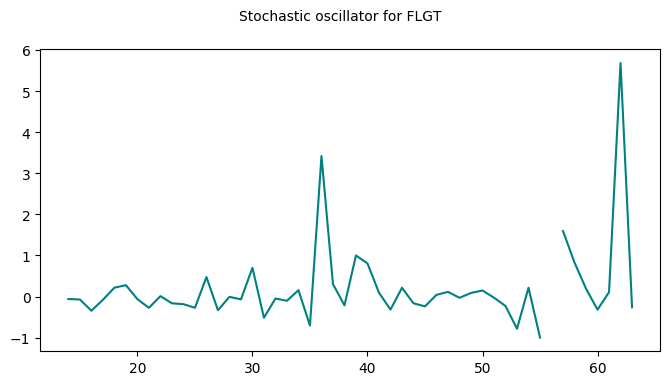

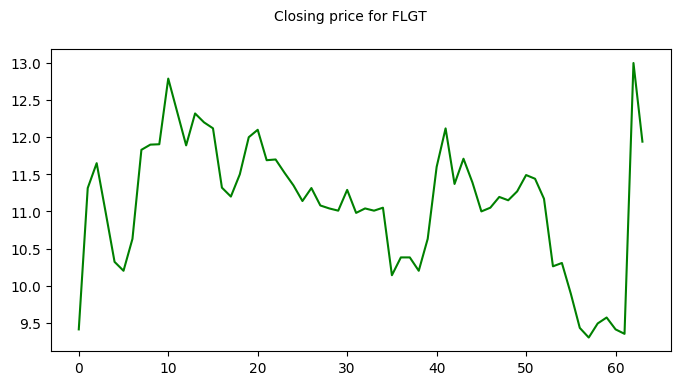

In [5]:
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Indicators for {} plotted together".format(ticker), fontsize=10)
plt.plot(ticker_cluster["open"], color="orange")
plt.plot(ticker_cluster["high"], color="blue")
plt.plot(ticker_cluster["low"], color="red")
plt.plot(ticker_cluster["close"], color="green")
plt.plot(ticker_cluster["bb_up"], color="black")
plt.plot(ticker_cluster["bb_low"], color="black")
plt.plot(ticker_cluster["apz_u"], color="grey")
plt.plot(ticker_cluster["apz_l"], color="grey")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Stochastic oscillator for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["stoch"].pct_change(), color="teal")
fig = plt.figure(figsize=(8,4), dpi=100)
fig.suptitle("Closing price for {}".format(ticker), fontsize=10)
plt.plot(ticker_cluster["close"], color="green")

In [6]:
# Heatmap time -- had to create a separate dataframe sans date index column for this 
nd = pd.DataFrame()
nd["close"]     = ticker_cluster["close"]
nd["macd"]      = ticker_cluster["open"]
nd["signal"]    = ticker_cluster["open"]
nd["mfi"]       = ticker_cluster["open"]
nd["vzo"]       = ticker_cluster["open"]
nd["volume"]    = ticker_cluster["open"]
nd["bb_up"]     = ticker_cluster["bb_up"]
nd["bb_low"]    = ticker_cluster["bb_low"]
heatmap = go.Heatmap(
    z=nd.iloc[-50:].pct_change().corr(method='pearson').values,
    x=nd.columns,
    y=nd.columns,
    colorbar=dict(title='Pearson Coefficient'),
)
layout = go.Layout(title="Pearson correlation of indicators")
heatmap['zmax'] = 1.0
heatmap['zmin'] = -1.0
fig = go.Figure(data=[heatmap], layout=layout)
py.iplot(fig)

In [7]:
# ticker_cluster

In [8]:
if __name__ == '__main__':
    get_gainers()
    print()
    get_losers()
    

                   Gainers                   

Symbol     Last        Change      Pct Gain
–––––––––––––––––––––––––––––––––––––––––––––
CBO        $19         $13.55      248.624%
SAUC       $1.04       $0.57       121.277%
FCEL       $0.5235     $0.256      95.409%
CNST       $25.6       $10.83      73.324%
CHEKW      $0.0349     $0.014      66.19%
OTLKW      $0.17       $0.06       54.545%
OXBRW      $0.06       $0.02       50%
AMRHW      $0.1        $0.031      44.928%
PNRL       $2.2        $0.56       34.146%
TACOW      $0.2        $0.05       33.333%
BNGOW      $0.16       $0.04       33.333%
WIFI       $12.62      $2.92       30.103%
ASLN       $2.28       $0.52       29.545%
ATISW      $0.0612     $0.014      29.387%
AQST       $5.37       $1.14       26.95%
SCOR       $3.15       $0.66       26.506%
ROSEW      $0.2        $0.04       25%
TEUM       $0.44       $0.087      24.575%
VNTR       $3.65       $0.72       24.573%
TRUP       $29.62      $5.58       23.211%
ADMP       